# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [2]:
# 데이터셋 종류 : load_digits
data = load_digits()

In [3]:
input = data.data
output = data.target

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [6]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.], device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [8]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [9]:
x_train.shape, y_train.unique()

(torch.Size([1257, 64]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0'))

In [10]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까? 
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,398, bias=True), 
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [11]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,398, bias=True), # input_layer = 64, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,64, bias=True), # hidden_layer1 = 398, hidden_layer2 = 64
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(64,16, bias=True), # hidden_layer1 = 64, hidden_layer2 = 16
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 10, bias=True), # hidden_layer3 = 16, output_layer = 10
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [12]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [13]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [14]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [15]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [16]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.305664300918579
10 2.105833053588867
20 1.9356894493103027
30 1.7570006847381592
40 1.6262723207473755
50 1.5519496202468872
60 1.5149409770965576
70 1.4979032278060913
80 1.488685965538025
90 1.483151912689209


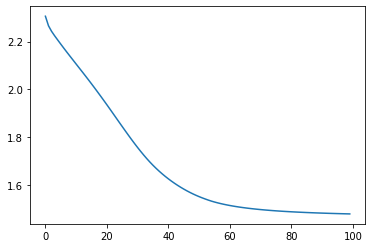

In [17]:
plt.plot(losses)
plt.show()

In [18]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [19]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [3.3206590e-03 9.7533166e-01 5.1923509e-04 1.3487122e-03 8.1459410e-04
 3.4477911e-03 1.8101545e-04 3.7555597e-03 9.6871378e-03 1.5935728e-03]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


0 2.3018414974212646
10 1.668643832206726
20 1.4798201322555542
30 1.465045690536499


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.462934970855713
50 1.4623829126358032
60 1.4621506929397583
70 1.4620249271392822
80 1.4619417190551758
90 1.4618781805038452


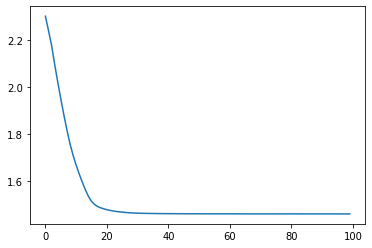

model의 output은 :  [6.3044013e-07 9.9969888e-01 1.6755979e-05 1.0467819e-05 2.3376115e-06
 1.4269732e-06 3.0635255e-07 1.4316746e-04 1.1740369e-04 8.6791870e-06]
argmax를 한 후의 output은 1
accuracy는 0.9685185185185186


In [20]:
# learning rate 변경 0.01 -> 0.05

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.05)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

0 2.3024280071258545
10 2.242831230163574
20 2.2072927951812744
30 2.1778619289398193
40 2.1508004665374756


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 2.124539375305176
60 2.0987019538879395
70 2.0728819370269775
80 2.047084093093872
90 2.021268367767334


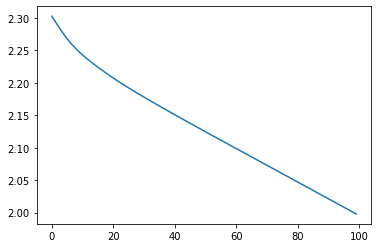

model의 output은 :  [0.04344594 0.5134491  0.08210436 0.03151264 0.01767083 0.11110714
 0.04001703 0.0862385  0.0171916  0.05726289]
argmax를 한 후의 output은 1
accuracy는 0.7907407407407407


In [21]:
# learning rate 변경 0.01 -> 0.001

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

0 2.3018062114715576
10 1.66156005859375
20 1.5343823432922363


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


30 1.4712603092193604
40 1.4651141166687012
50 1.4640666246414185
60 1.4637794494628906
70 1.4635969400405884
80 1.4634790420532227
90 1.4634047746658325


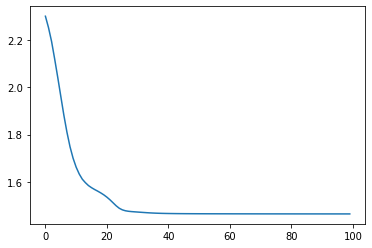

model의 output은 :  [8.4518506e-05 9.9926406e-01 1.2185496e-04 5.2594322e-07 2.8396994e-04
 3.8126968e-06 2.1525566e-05 1.6081249e-06 1.8253787e-04 3.5605430e-05]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


In [22]:
### 최고 성능 시도. acc : 0.98333...
### optimizer : adam, lr : 0.05
### layer, activation function : hidden layer 2개, sigmoid


# learning rate 변경 0.01 -> 0.05

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.05)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

0 2.3034005165100098
10 1.888708233833313
20 1.7035841941833496
30 1.576636791229248
40 1.5016529560089111


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.4803763628005981
60 1.4722214937210083
70 1.4682995080947876
80 1.4663498401641846
90 1.4650133848190308


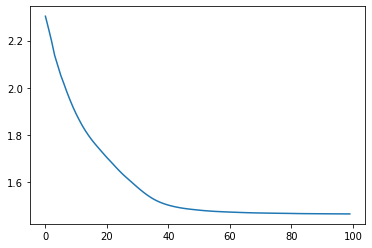

model의 output은 :  [3.3601780e-05 9.9463707e-01 1.4919022e-03 1.1858140e-04 2.3597679e-03
 1.2887611e-04 2.4351660e-04 2.2267765e-05 7.5893727e-04 2.0548144e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


In [23]:
# hidden layer 개수 변경 2개 => 1개

model = nn.Sequential(
          nn.Linear(64,398, bias=True), 
          nn.Sigmoid(),
          nn.Linear(398,32, bias=True),
          nn.Sigmoid(),
          nn.Linear(32,10, bias=True), 
          nn.Softmax()
          ).to(device)

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

0 2.3191311359405518
10 2.262218713760376
20 2.2592694759368896
30 2.2589213848114014
40 2.259160280227661
50 2.259770631790161
60 2.2597179412841797


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


70 2.258969783782959
80 2.2580864429473877
90 2.258035898208618


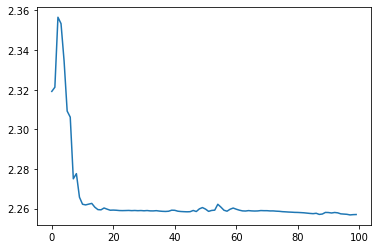

model의 output은 :  [0.0000000e+00 1.0000000e+00 1.0805906e-21 0.0000000e+00 0.0000000e+00
 7.5374868e-17 0.0000000e+00 5.4372487e-12 0.0000000e+00 0.0000000e+00]
argmax를 한 후의 output은 1
accuracy는 0.20185185185185187


In [24]:
# activation function 변경(relu)
# hidden layer 개수 변경 2개 => 1개

model = nn.Sequential(
          nn.Linear(64,398, bias=True), 
          nn.ReLU(),
          nn.Linear(398,32, bias=True),
          nn.ReLU(),
          nn.Linear(32,10, bias=True), 
          nn.Softmax()
          ).to(device)

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

0 2.292294979095459
10 1.8097691535949707
20 1.559287190437317
30 1.4893125295639038


<ipython-input-12-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


40 1.4732130765914917
50 1.4679936170578003
60 1.465144157409668
70 1.4635554552078247
80 1.4630028009414673
90 1.4626983404159546


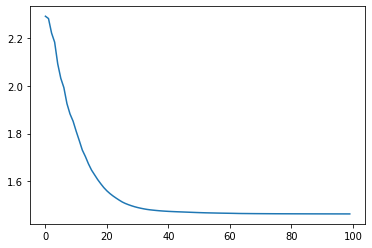

model의 output은 :  [4.5136841e-07 9.9891055e-01 1.6376701e-04 9.5659052e-06 2.8106067e-04
 6.6312041e-06 4.3623433e-05 1.8851777e-05 5.6041573e-04 5.0044264e-06]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


In [25]:
# tanh
# hidden layer 개수 변경 2개 => 1개

model = nn.Sequential(
          nn.Linear(64,398, bias=True), 
          nn.Tanh(),
          nn.Linear(398,32, bias=True),
          nn.Tanh(),
          nn.Linear(32,10, bias=True), 
          nn.Softmax()
          ).to(device)

model.to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())
    
plt.plot(losses)
plt.show()

with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

# < 3주차 과제 2 : CNN 맛보기>

In [26]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [27]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [28]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은? 16 * 20?

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

In [29]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [30]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [31]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [32]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-28-b23b31dbd079>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315630
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298709
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.276746
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.222318
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.223083
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.166535
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.121441
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.042016
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.922761
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.794014
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.615482
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.315181
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.160963
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.844352
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.899190
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.761823
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.912261
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.724659
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.580572
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.571917
Train Epoch: 1 [12800/60000 (

<ipython-input-31-f52337105c2a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1775, Accuracy: 9445/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.291847
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.293238
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.213193
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.076567
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.218453
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.257237
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.129913
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.262990
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.112069
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.107212
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.134271
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.191028
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.248968
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.198147
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.124054
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.299285
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.225338
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.180691
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.390732
Train Epoch: 2 [12